In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import csv
import string
from textblob import TextBlob as blob
from scipy import stats
from pymongo import MongoClient
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import sentiment as vaderSentiment 

# sentiment analysis
from textblob.sentiments import NaiveBayesAnalyzer
from pattern.en import sentiment, mood, modality, wordnet, ADJECTIVE

# text parsing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spacy.en import English, STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import TweetTokenizer


# modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
import lda
from sklearn.decomposition import PCA, LatentDirichletAllocation

# visualization
import pyLDAvis

%matplotlib inline

/Users/nickryan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
nltk.download('punkt')

True

In [154]:
from pymongo import MongoClient

client = MongoClient()
db = client.test

# pull tweets out of mongo
def out_of_mongo(collection):
    tweet_list = []
    for tweet in collection.find():
        tweet_list.append(tweet)
    return tweet_list

In [155]:
# trump data
dt_data = out_of_mongo(db.trumptweets3)

In [156]:
len(dt_data)

3199

In [157]:
with open('pickled/tweetslong.pickle', 'wb') as handle:
    pickle.dump(dt_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [158]:
with open('pickled/tweetslong.pickle', 'rb') as handle:
  b = pickle.load(handle)

In [160]:
# convert to pandas df
def data_to_df(data):
    # variables explained: https://dev.twitter.com/overview/api/tweets
    df = pd.DataFrame(data)
    df.drop_duplicates(subset = 'id', inplace = True)
    keep = ['id', 'created_at', 'text', 
            'favorite_count', 'retweet_count',  
            'is_quote_status', 'quoted_status', 'quoted_status_id', 
            'in_reply_to_screen_name', 'in_reply_to_status_id', 'retweeted_status', 
            'entities', 'source']
    df = df[keep]
    return df

dt = data_to_df(dt_data)

In [161]:
dt.describe()

,id,favorite_count,retweet_count,quoted_status_id,in_reply_to_status_id
count,3.184000e+03,3184.000000,3184.000000,7.000000e+01,1.000000e+00
mean,7.193127e+17,14638.560616,5242.841080,7.195472e+17,7.667416e+17
std,2.653733e+16,13367.874565,5772.219928,2.355640e+16,NaN
min,6.784247e+17,0.000000,405.000000,6.784228e+17,7.667416e+17
25%,6.964426e+17,6446.250000,2282.000000,NaN,NaN
50%,7.142374e+17,11459.000000,3998.500000,NaN,NaN
75%,7.417473e+17,19164.000000,6565.750000,NaN,NaN
max,7.697406e+17,292514.000000,168586.000000,7.689335e+17,7.667416e+17


In [148]:
dt.shape

(797, 13)

In [162]:
def is_retweet(retweeted_status):
    """Check if tweet is retweet."""
    try:
        if np.isnan(retweeted_status) == True:
            return 
    except:
        return 1
    
def get_week(date):
    """Return start of week (Monday) given a date."""
    week = date - timedelta(days = date.weekday())
    return week

def add_metadata(df):
    """Add date, is retweet, month, and week features to df."""
    # add date as datetime object
    df.loc[:, 'date'] = df.loc[:, 'created_at'].apply(lambda x: pd.to_datetime(x).date())
    
    # add if retweet
    df.loc[:, 'is_retweet'] = df.loc[:, 'retweeted_status'].apply(is_retweet)
    
    # add week
    df.loc[:, 'week'] = df.loc[:, 'date'].apply(get_week)
    
    # add month
    df.loc[:, 'month'] = df.loc[:, 'date'].apply(lambda x: x.replace(day = 1))

In [163]:
add_metadata(dt)

In [164]:
def plot_feats(df, featurelist): 
    """Plot features of dataframe
    Args:
    df (dataframe) -- dataframe
    featurelist (list) -- list of features to plot
    """    
    plt.figure(figsize = (20, 8))
    plt.title('Retweets and Favorites', fontsize = 14)
    for feature in featurelist:
        plt.plot(df[feature])
    plt.legend(loc = 'best')
    plt.show()

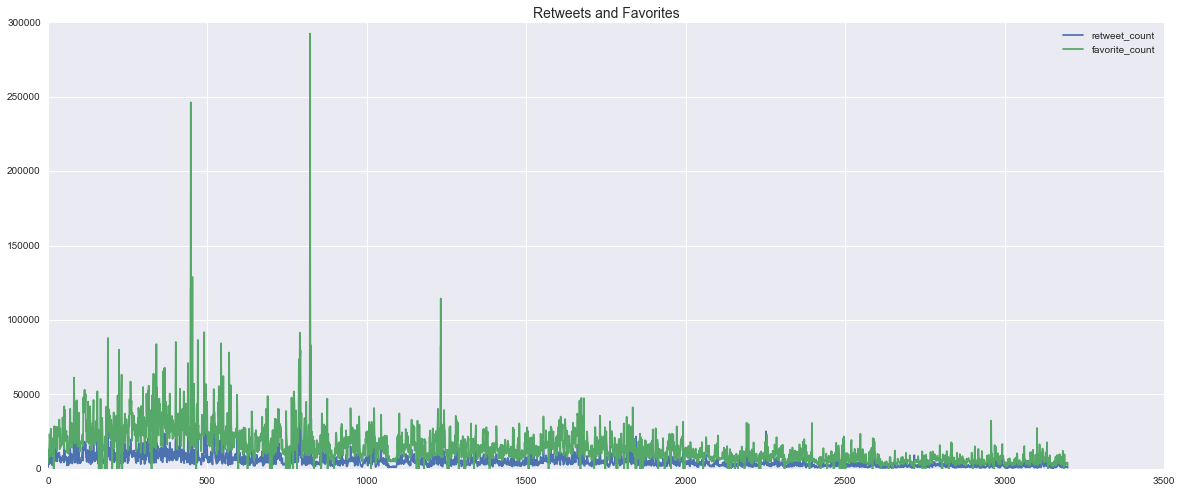

In [169]:
# compare retweets vs. favorites (tweets ordered new to old, left to right)

plot_feats(dt, ['retweet_count', 'favorite_count'])

In [166]:
# group by date

groupby_date_fav = dt['favorite_count'].groupby(dt['date'])
groupby_date_rt = dt['retweet_count'].groupby(dt['date'])

In [167]:
meanfav_df = groupby_date_fav.mean()
meanrt_df = groupby_date_rt.mean()
meanfav_df.head()
meanrt_df.head()

date
2015-12-20    1848.176471
2015-12-21    2331.142857
2015-12-22    1317.285714
2015-12-23    3167.263158
2015-12-24    2981.533333
Name: retweet_count, dtype: float64

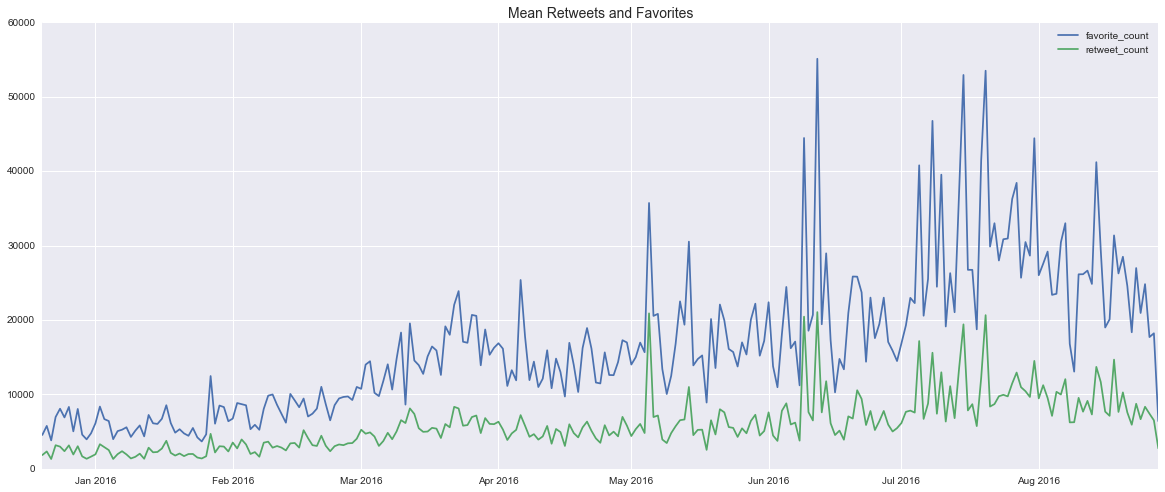

In [168]:
# favorites and retweets reduced variance (by date)

def plot_compare(dfs): 
    plt.figure(figsize = (20, 8))
    plt.title('Mean Retweets and Favorites', fontsize = 14)
    for df in dfs:
        plt.plot(df)
    plt.legend(loc = 'best')
    plt.show()
    
plot_compare([meanfav_df, meanrt_df])

In [170]:
# Tokenize tweets, with a number of options:
#
# word_tokenizer from nltk
# TweetTokenizer from nltk
# Custom tokenizer from https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [171]:
dt.loc[:, 'sentences'] = dt.loc[:, 'text'].apply(sent_tokenize)
dt.loc[:, 'tokens']    = dt.loc[:, 'text'].apply(preprocess)

In [174]:
# get tweets, remove links and @ mentions, and export for neural net training
tweettext = dt['text']
tweettext = tweettext.replace({r"(?:\@|https?\://)\S+": ""}, regex=True)
tweettext.to_csv('alltweets.csv', encoding='utf-8')

In [21]:
dt['source'].value_counts()

<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>    276
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>      272
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       49
<a href="http://instagram.com" rel="nofollow">Instagram</a>                               2
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>         1
Name: source, dtype: int64

In [22]:
keys = {'<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>': 'Android', 
        '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'iPhone', 
        '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Web'}
dt = dt.replace({"source": keys})

In [23]:
# import emotion lexicon
emotion_lexicon = pd.read_csv('NRC_Emotion_Lexicon.csv', header=0)
emotion_lexicon[1:20]

,English Word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,1,0,0,0,1,0,1,0,0
3,abandoned,0,1,1,0,0,1,0,1,0,0
4,abandonment,0,1,1,0,0,1,0,1,1,0
5,abate,0,0,0,0,0,0,0,0,0,0
6,abatement,0,0,0,0,0,0,0,0,0,0
7,abba,1,0,0,0,0,0,0,0,0,0
8,abbot,0,0,0,0,0,0,0,0,0,1
9,abbreviate,0,0,0,0,0,0,0,0,0,0
10,abbreviation,0,0,0,0,0,0,0,0,0,0


In [106]:
'crooked' in emotion_lexicon['English Word']

False

In [134]:
emotion_lexicon.loc[1]=['crooked', 0,1,0,0,1,0,0,0,0,0] 

In [24]:
affects = ['Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust',
           'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']

# create emotion dictionary
emotion_words = dict()
for key in affects:
    emotion_words[key] = emotion_lexicon[(emotion_lexicon[key] == 1)]['English Word'].tolist()

In [25]:
# counts number of words in tweet matching values in emotion dictionary for a given emotion
def emotioncount(df, emotion):
    col = []
    for line in df:
        emotcount = 0
        for word in line:
            if word in emotion_words[emotion]:
                emotcount = emotcount + 1
        col.append(emotcount)
    return col

In [26]:
dt.loc[:, 'number of tokens'] = dt['tokens'].apply(len)

for affect in affects:
    dt.loc[:, affect] = emotioncount(dt['tokens'], affect)
    dt.loc[:, affect + " ratio"] = dt[affect] / dt['number of tokens']
    
dt.head()

,id,created_at,text,favorite_count,retweet_count,is_quote_status,quoted_status,quoted_status_id,in_reply_to_screen_name,in_reply_to_status_id,...,Fear,Fear ratio,Joy,Joy ratio,Sadness,Sadness ratio,Surprise,Surprise ratio,Trust,Trust ratio
0,762284533341417472,Sun Aug 07 13:49:29 +0000 2016,I see where Mayor Stephanie Rawlings-Blake of ...,18689,6343,False,NaN,NaN,None,None,...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.000000
1,762110918721310721,Sun Aug 07 02:19:37 +0000 2016,"Thank you Windham, New Hampshire! #TrumpPence1...",15984,4818,False,NaN,NaN,None,None,...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.000000
2,762106904436961280,Sun Aug 07 02:03:39 +0000 2016,.@Larry_Kudlow - 'Donald Trump Is the middle-c...,16312,6547,False,NaN,NaN,None,None,...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.000000
3,762104411707568128,Sun Aug 07 01:53:45 +0000 2016,I am not just running against Crooked Hillary ...,60500,19862,False,NaN,NaN,None,None,...,0,0.0,0,0.0,1,0.037037,0,0.0,0,0.000000
4,762016426102296576,Sat Aug 06 20:04:08 +0000 2016,#CrookedHillary is not fit to be our next pres...,21357,7160,False,NaN,NaN,None,None,...,0,0.0,0,0.0,0,0.000000,0,0.0,1,0.083333


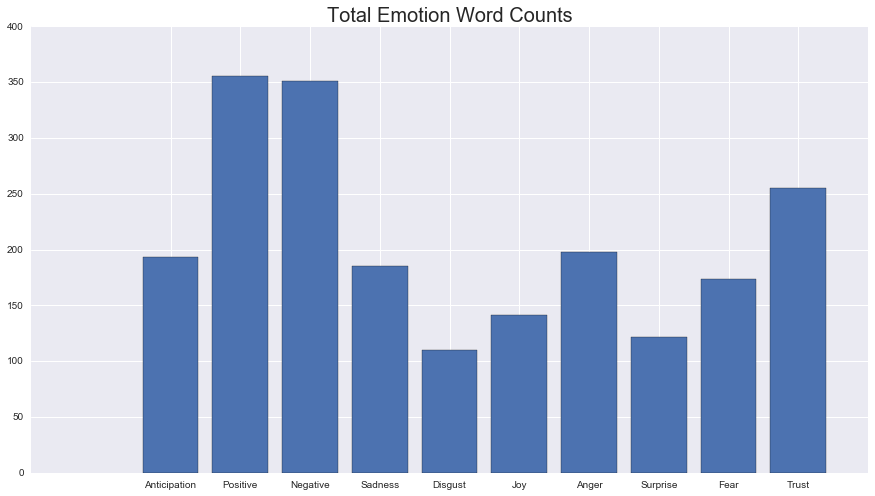

In [27]:
emotion_sums = dict()
for key in affects:
    emotion_sums[key] = sum(dt[key])

plt.figure(figsize=(15,8))
plt.title('Total Emotion Word Counts', fontsize = 20)
plt.bar(range(len(emotion_sums)), emotion_sums.values(), align='center', )
plt.xticks(range(len(emotion_sums)), emotion_sums.keys())

plt.show()

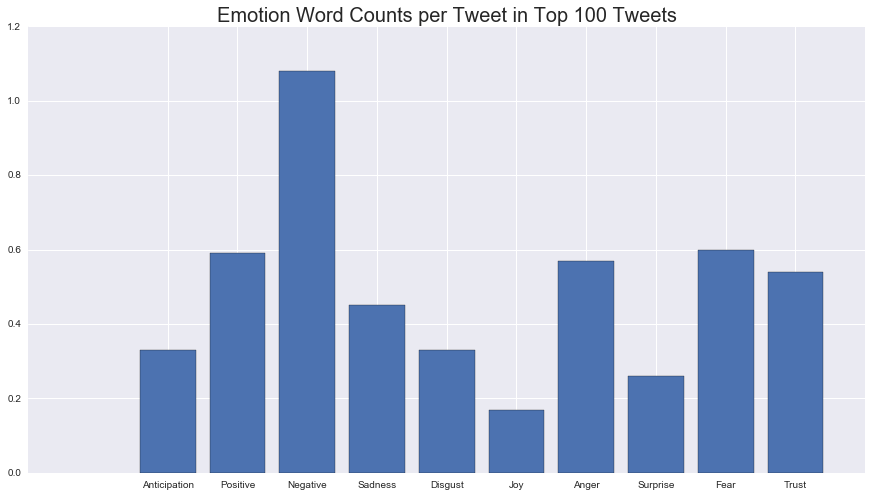

In [28]:
by_favorite = dt.sort(['favorite_count'], ascending = False)

emotion_sums = dict()
for key in affects:
    emotion_sums[key] = sum(by_favorite[key][:100]) / 100.0

plt.figure(figsize=(15,8))
plt.title('Emotion Word Counts per Tweet in Top 100 Tweets', fontsize = 20)
plt.bar(range(len(emotion_sums)), emotion_sums.values(), align='center', )
plt.xticks(range(len(emotion_sums)), emotion_sums.keys())

plt.show()

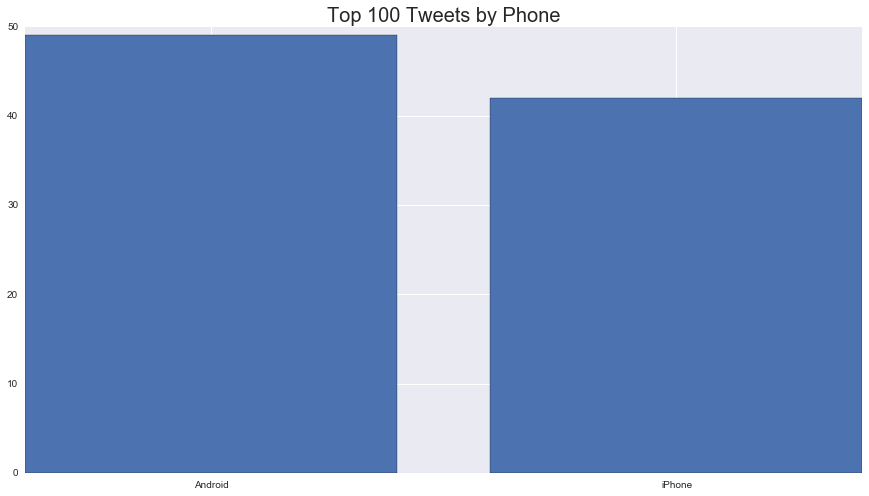

In [29]:
phones = ['Android', 'iPhone']
top_100_by_phone = dict()
for key in phones:
    top_100_by_phone[key] = len(by_favorite['source'][:100][by_favorite['source'] == key])
    
plt.figure(figsize=(15,8))
plt.title('Top 100 Tweets by Phone', fontsize = 20)
plt.bar(range(len(top_100_by_phone)), top_100_by_phone.values(), align='center', )
plt.xticks(range(len(top_100_by_phone)), top_100_by_phone.keys())

plt.show()

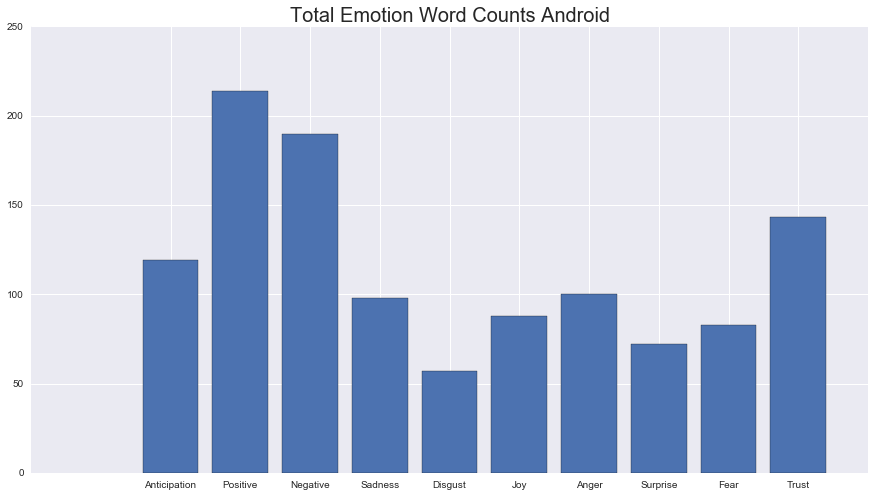

In [30]:
emotion_sums_android = dict()
for key in affects:
    emotion_sums_android[key] = sum(dt[key][dt['source']=='Android'])

plt.figure(figsize=(15,8))
plt.title('Total Emotion Word Counts Android', fontsize = 20)
plt.bar(range(len(emotion_sums_android)), emotion_sums_android.values(), align='center', )
plt.xticks(range(len(emotion_sums_android)), emotion_sums_android.keys())

plt.show()

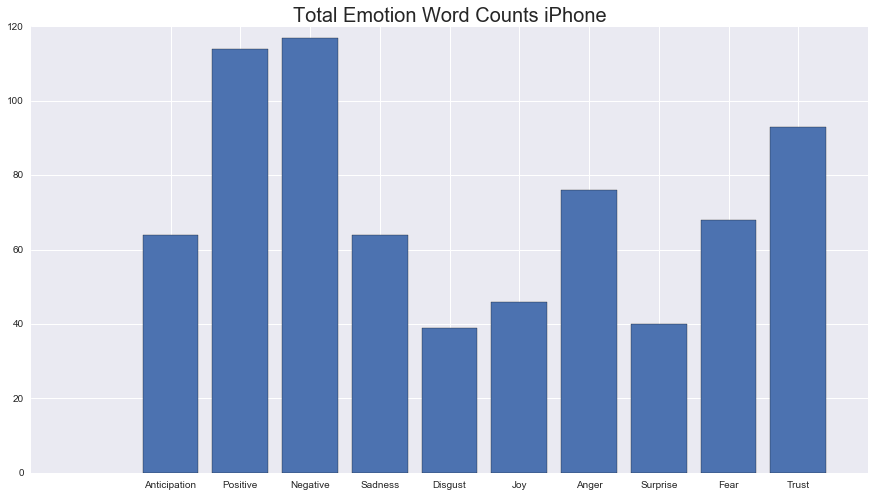

In [31]:
emotion_sums_iphone = dict()
for key in affects:
    emotion_sums_iphone[key] = sum(dt[key][dt['source']=='iPhone'])

plt.figure(figsize=(15,8))
plt.title('Total Emotion Word Counts iPhone', fontsize = 20)
plt.bar(range(len(emotion_sums_iphone)), emotion_sums_iphone.values(), align='center', )
plt.xticks(range(len(emotion_sums_iphone)), emotion_sums_iphone.keys())

plt.show()

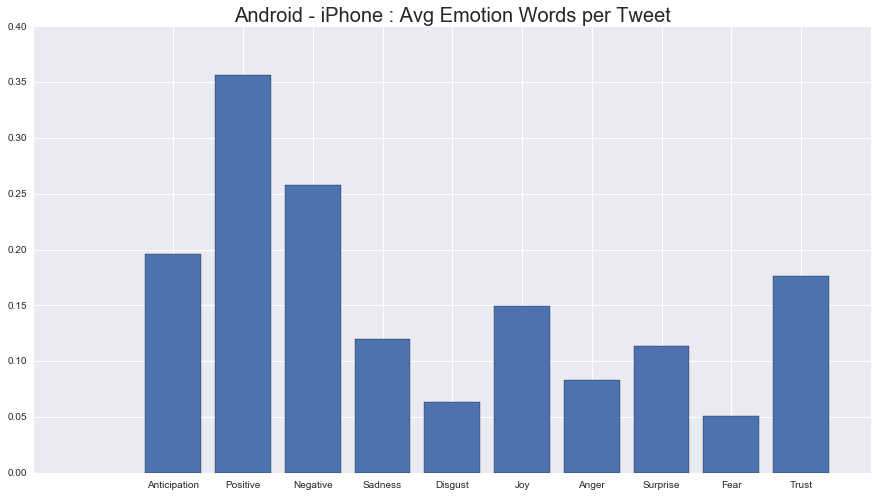

In [32]:
# almost same number of iPhone/Android tweets, Android tweets contain more emotion words on average in all categories

emotion_avg_iphone = {key: (emotion_sums_iphone[key] / float(len(dt[dt['source']=='iPhone'])))  for key in emotion_sums_iphone.keys()}
emotion_avg_android = {key: (emotion_sums_android[key] / float(len(dt[dt['source']=='Android'])))  for key in emotion_sums_android.keys()}

emotions_diff = {key: emotion_avg_android[key] - emotion_avg_iphone.get(key, 0) for key in emotion_avg_android.keys()}

plt.figure(figsize=(15,8))
plt.title('Android - iPhone : Avg Emotion Words per Tweet', fontsize = 20)
plt.bar(range(len(emotions_diff)), emotions_diff.values(), align='center', )
plt.xticks(range(len(emotions_diff)), emotions_diff.keys())

plt.show()

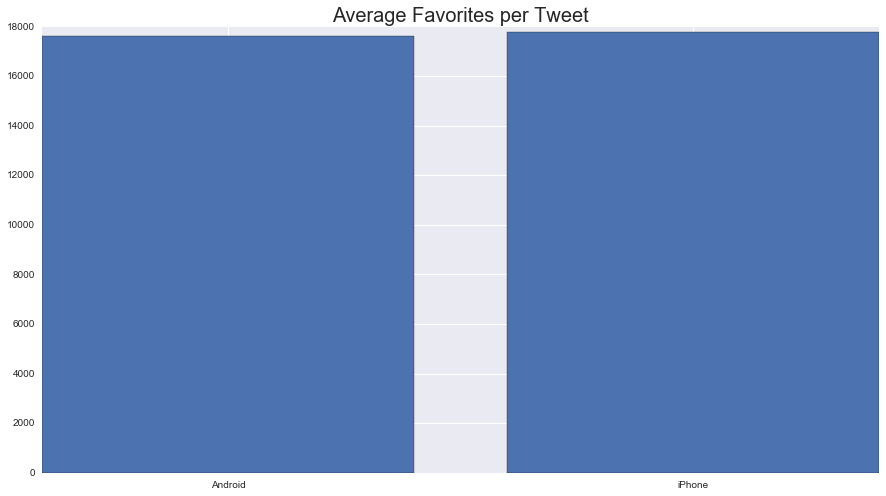

In [33]:
phones = ['Android', 'iPhone']
favorite_by_phone = dict()
for key in phones:
    favorite_by_phone[key] = sum(dt['favorite_count'][dt['source'] == key]) / len(dt[dt['source'] == key])

plt.figure(figsize=(15,8))
plt.title('Average Favorites per Tweet', fontsize = 20)
plt.bar(range(len(favorite_by_phone)), favorite_by_phone.values(), align='center', )
plt.xticks(range(len(favorite_by_phone)), favorite_by_phone.keys())

plt.show()

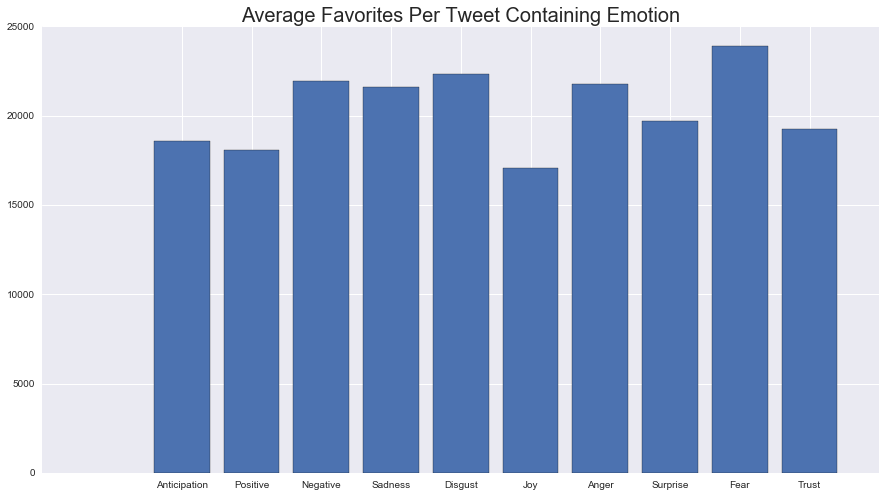

In [34]:
favorite_emotions = dict()
for key in affects:
    favorite_emotions[key] = sum(dt['favorite_count'][dt[key] > 0]) / len(dt[dt[key] > 0])

plt.figure(figsize=(15,8))
plt.title('Average Favorites Per Tweet Containing Emotion', fontsize = 20)
plt.bar(range(len(favorite_emotions)), favorite_emotions.values(), align='center', )
plt.xticks(range(len(favorite_emotions)), favorite_emotions.keys())

plt.show()

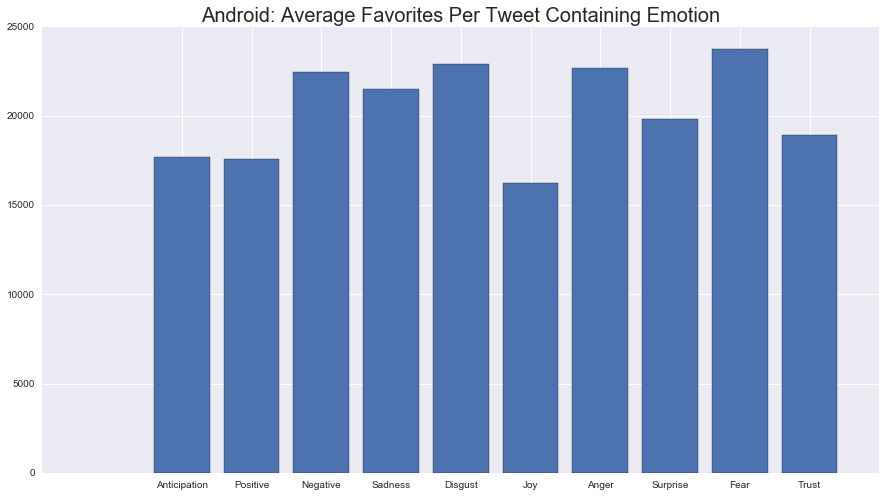

In [35]:
android_favorite_emotions = dict()
for key in affects:
    android_favorite_emotions[key] = sum(dt['favorite_count'][dt[key] > 0][dt['source'] == 'Android']) / len(dt[dt[key] > 0][dt['source'] == 'Android'])

plt.figure(figsize=(15,8))
plt.title('Android: Average Favorites Per Tweet Containing Emotion', fontsize = 20)
plt.bar(range(len(android_favorite_emotions)), android_favorite_emotions.values(), align='center', )
plt.xticks(range(len(android_favorite_emotions)), android_favorite_emotions.keys())

plt.show()

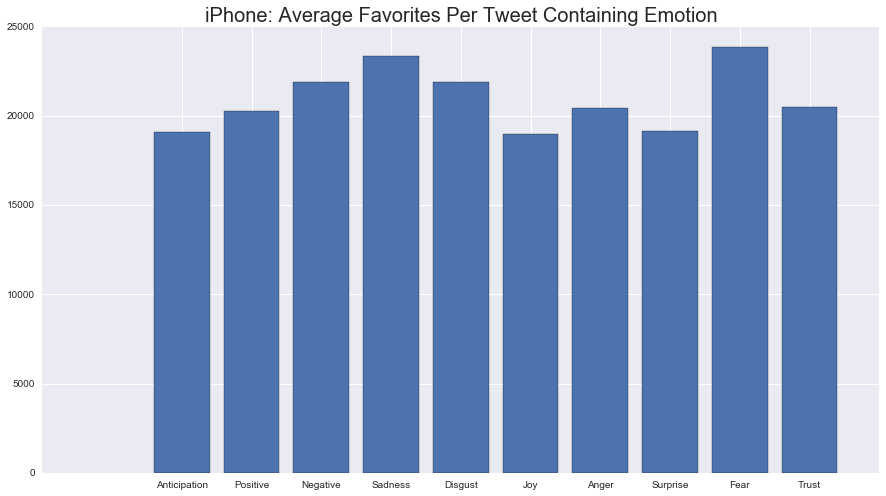

In [81]:
iphone_favorite_emotions = dict()
for key in affects:
    iphone_favorite_emotions[key] = sum(dt['favorite_count'][dt[key] > 0][dt['source'] == 'iPhone']) / len(dt[dt[key] > 0][dt['source'] == 'iPhone'])

plt.figure(figsize=(15,8))
plt.title('iPhone: Average Favorites Per Tweet Containing Emotion', fontsize = 20)
plt.bar(range(len(iphone_favorite_emotions)), iphone_favorite_emotions.values(), align='center', )
plt.xticks(range(len(iphone_favorite_emotions)), iphone_favorite_emotions.keys())

plt.show()

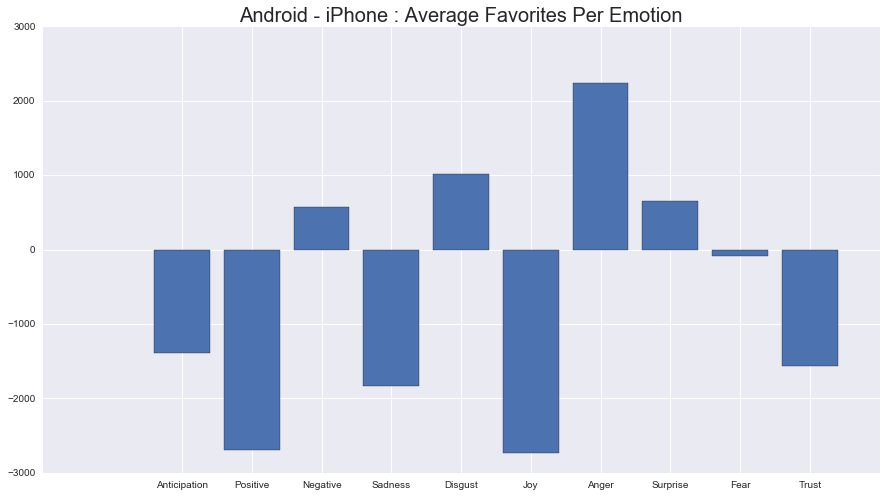

In [43]:
fav_emotions_diff = {key: android_favorite_emotions[key] - iphone_favorite_emotions.get(key, 0) for key in android_favorite_emotions.keys()}

plt.figure(figsize=(15,8))
plt.title('Android - iPhone : Average Favorites Per Emotion', fontsize = 20)
plt.bar(range(len(fav_emotions_diff)), fav_emotions_diff.values(), align='center', )
plt.xticks(range(len(fav_emotions_diff)), fav_emotions_diff.keys())

plt.show()

Insights:
- Android tweets are more emotional
- Among the top favorited tweets, negativity and fear dominate
- Tweets with fear and disgust get more favorites overall
- More top tweets come from Android
- Overall, Android and iPhone have similar distribution of emotions
- Despite having similar proportions of emtions, Android tweets conveying negativity, disgust, anger, and surprise garner  significantly more favorites, and iPhone tweets conveying anticipation, positivity, sadness, joy, and trust garner significantly more favorites
- Android is better at garnering favorites from negative sentiments, iPhone is better at garnering favorites from positive sentiments; each one is attracting a different kind of audience

In [38]:
def get_word_counts(df):
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = 'english', 
                                       max_features = 1000,
                                       ngram_range = (1, 3), 
                                       min_df = 3) 
    matrix = count_vect.fit_transform(df['text'])
    grams = count_vect.get_feature_names()
    dist = np.sum(matrix.toarray(), axis = 0)
    grams_sorted = sorted(zip(grams, dist), key = lambda x: x[1], reverse = True)[:10]

In [79]:
import sys

In [39]:
get_word_counts(dt)

In [72]:
def clusters(df, clusters_count = 5):
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = 'english', 
                                       max_features = 20000,
                                       ngram_range = (1, 3), 
                                       min_df = 3) 
    matrix = count_vect.fit_transform(df['text'])
    grams = count_vect.get_feature_names()
    km = KMeans(n_clusters = clusters_count)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(clusters_count):
        print "\nCluster %d:" % i
        print ', '.join([grams[ind] for ind in order_centroids[i, :50]]) 
    return km

In [75]:
clusters(dt)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [76]:
from sklearn.feature_extraction import text 

def clusters_tfidf(df, clusters_count = 5):
    vect = TfidfVectorizer(max_df = 0.5, max_features = 200000,
                                 min_df = 5, stop_words = text.ENGLISH_STOP_WORDS.union(['https']),
                                 use_idf = True, tokenizer = None, ngram_range=(1, 1))
    matrix = vect.fit_transform(df['text']) 
    terms = vect.get_feature_names()
    km = KMeans(n_clusters = clusters_count)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(clusters_count):
        print "\nCluster %d:" % i
        print ', '.join([terms[ind] for ind in order_centroids[i, :50]]) 
    return km

In [78]:
clusters_tfidf(dt)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Some bug is sending output to terminal...Here's what it produced:

Cluster 0:
people, great, crookedhillary, amp, join, just, good, president, tonight, cnn, america, want, poll, bernie, isis, convention, new, 7pm, make, media, obama, foxnews, trump2016, country, tomorrow, night, iowa, job, today, tough, going, amazing, 00, read, don, americafirst, imwithyou, watch, statement, dishonest, bad, american, totally, right, like, sad, tickets, speech, interviewed, thanks

Cluster 1:
thank, americafirst, great, trump2016, imwithyou, support, maga, soon, words, nice, trumppence16, iowa, foxnews, colorado, amazing, making, people, amp, enforcement, highly, virginia, officers, texas, law, tonight, ohio, night, cnn, work, vote, mike_pence, nevada, las, vegas, new, just, hampshire, way, debate, safe, today, big, yesterday, america, good, fight, donald, dallas, united, states

Cluster 2:
hillary, clinton, crooked, bad, just, cnn, change, judgement, obama, believe, jobs, totally, country, isis, meeting, money, said, state, really, people, judgment, wrong, brexit, says, did, bernie, want, president, speech, donald, election, got, amp, massive, tpp, know, wall, street, radical, work, run, knew, sanders, world, refugees, person, wants, imwithyou, worse, like

Cluster 3:
realdonaldtrump, trump, donald, rt, cnn, oreillyfactor, speech, president, anncoulter, poll, amp, real, jaketapper, debate, hillary, time, lindseygrahamsc, love, trump2016, country, need, just, hope, campaign, pay, america, piersmorgan, like, potus, national, vote, foxnews, don, new, best, fox, ready, dems, mr, peggynoonannyc, ll, did, news, voters, iowa, 41, cruz, lead, republican, media

Cluster 4:
makeamericagreatagain, trump2016, thank, poll, new, realdonaldtrump, support, florida, let, gopdebate, abc, post, great, foxnews, amp, tickets, debate, record, pennsylvania, colorado, america, way, far, iowa, seanhannity, ohio, hampshire, 20, crowd, watch, virginia, join, mr, tonight, doing, imwithyou, time, just, trump, isis, like, know, knows, las, law, lead, got, good, knew, going



In [94]:
def print_top_words(model, feature_names, n_top_words = 20):
    """Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print "\nTopic #%d:" % topic_idx
        print ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

In [95]:
def get_topics_lda_tfidf(docs, df, n_topics = 5):   
    vect = TfidfVectorizer(max_df = 0.8, max_features = 200000,
                                 min_df = 5, stop_words = text.ENGLISH_STOP_WORDS.union(['https']),
                                 use_idf = True, tokenizer = None, ngram_range=(1, 1))
    matrix = vect.fit_transform(docs)
    vocab = vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=20,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    
    #print topic words
    print_top_words(lda, vocab)
    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [96]:

lda_tfidf, topics_tfidf, prepared_tfidf = get_topics_lda_tfidf(dt['text'], dt, 5)

In [99]:
prepared_tfidf

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      31.309290        1       1 -0.063323 -0.135960
4      30.002598        1       2 -0.106588  0.054266
3      22.891443        1       3  0.069527  0.102398
1       8.271550        1       4  0.151368 -0.054363
0       7.525119        1       5 -0.050984  0.033659, topic_info=     Category         Freq                   Term        Total  loglift  \
term                                                                      
199   Default  1555.000000                  thank  1555.000000  30.0000   
115   Default  1049.000000  makeamericagreatagain  1049.000000  29.0000   
92    Default   380.000000                   join   380.000000  28.0000   
37    Default   405.000000         crookedhillary   405.000000  27.0000   
65    Default   503.000000                foxnews   503.000000  26.0000   
214   Default  1077.000000              trump2016  107

In [103]:
pyLDAvis.display(prepared_tfidf)

In [105]:
list(dt)

[u'id',
 u'created_at',
 u'text',
 u'favorite_count',
 u'retweet_count',
 u'is_quote_status',
 u'quoted_status',
 u'quoted_status_id',
 u'in_reply_to_screen_name',
 u'in_reply_to_status_id',
 u'retweeted_status',
 u'entities',
 u'source',
 'date',
 'is_retweet',
 'week',
 'month',
 'sentences',
 'tokens',
 'number of tokens',
 'Positive',
 'Positive ratio',
 'Negative',
 'Negative ratio',
 'Anger',
 'Anger ratio',
 'Anticipation',
 'Anticipation ratio',
 'Disgust',
 'Disgust ratio',
 'Fear',
 'Fear ratio',
 'Joy',
 'Joy ratio',
 'Sadness',
 'Sadness ratio',
 'Surprise',
 'Surprise ratio',
 'Trust',
 'Trust ratio']